<a href="https://colab.research.google.com/github/Kittsxy/bank-stock-prediction-lstm/blob/main/BBNI%20Stocks%20Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime
import seaborn as sns
import math
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from keras.models import Sequential
from keras.layers import Bidirectional, Flatten, Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, Bidirectional, GRU, LSTM
from tensorflow.keras.regularizers import l1_l2

In [ ]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

# Z-Scores
def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
# Datetime
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [ ]:
# Multisteps Forecast
def multi_step_forecasts(n_lookback, n_forecast, model, data, data_scaled):

    input_forecast = data_scaled[-n_lookback:]
    x_forecast = input_forecast.reshape(1, n_lookback, 1)

    y_future = [] # predicted target values

    for i in range(n_forecast):
        # generate the next forecast
        output = model.predict(x_forecast)

        # transform the forecasts back to the original scale
        normal_output = inverse_normalize_series(output, Average(data), stdev(data.flatten()))

        # save the forecast
        y_future.append(list(normal_output[0]))

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_lookback:].reshape(1, n_lookback, 1)


    return y_future

In [ ]:
df = pd.read_csv("/content/BBNI.JK Close.csv",sep=";")

In [ ]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df.info()

<ipython-input-62-fe3be03317d7>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = df['Date'].apply(pd.to_datetime)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2726 non-null   datetime64[ns]
 1   Close   2726 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.7 KB


In [ ]:
df.head()

,Date,Close
0,2013-02-01,1862
1,2013-03-01,1862
2,2013-04-01,1900
3,2013-07-01,1900
4,2013-08-01,1937


In [ ]:
dataSize = len(df)
print(dataSize)

2726


In [ ]:
# Membuat date sequence

dataset_date = [dt.strftime('%Y-%m-%d') for dt in
       datetime_range(datetime(2013,2,1), datetime(2023,12,29),
       relativedelta(days=1))]

print(len(df))
print(np.shape(dataset_date))

2726
(3983,)


In [ ]:
# Mengonversi Skalar/Array/Series Menjadi Objek DateTime
# Ensure that the length of dataset_date matches the length of df
#dataset_date = dataset_date[:len(df)]  # Trim dataset_date to match df length

#df['Date'] = dataset_date
#df['Date'] = df['Date'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2726 non-null   datetime64[ns]
 1   Close   2726 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.7 KB


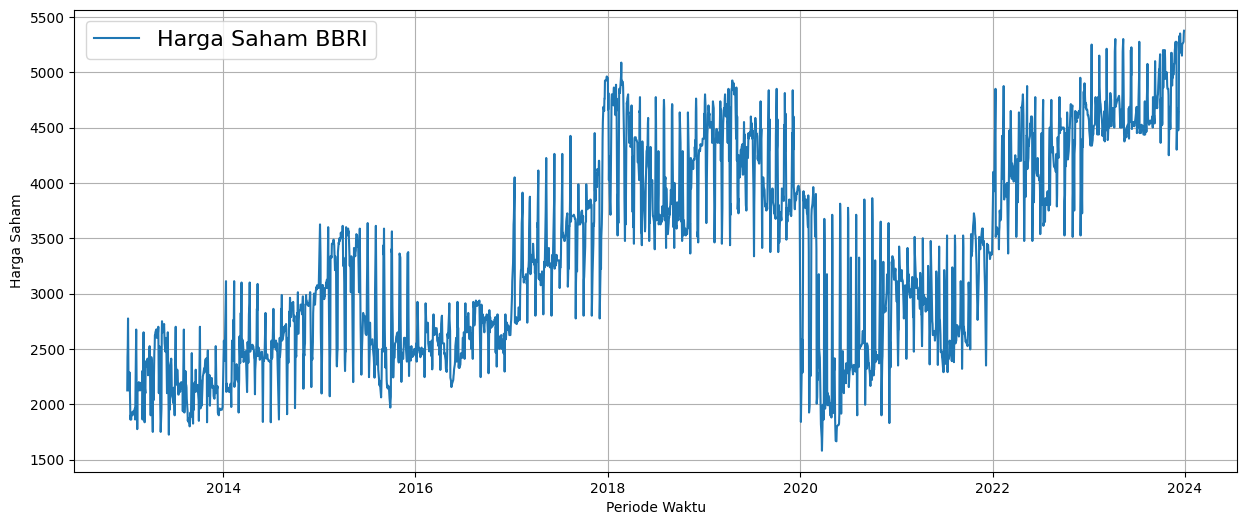

In [ ]:
# Plot Data
plt.subplots(figsize=(15, 6))
sns.lineplot(x="Date", y="Close", data=df, label='Harga Saham BBRI')
plt.xlabel('Periode Waktu')
plt.ylabel('Harga Saham')
plt.legend(loc='upper left', prop={'size': 16})
plt.grid()
plt.show()

In [ ]:
# Mengetahui Summary dari Dataset
df.describe()

,Date,Close
count,2726,2726.000000
mean,2018-06-30 05:27:30.770359296,3333.249083
min,2013-01-02 00:00:00,1580.000000
25%,2015-10-13 12:00:00,2525.000000
50%,2018-06-30 12:00:00,3250.000000
75%,2021-03-17 18:00:00,4125.000000
max,2023-12-29 00:00:00,5375.000000
std,NaN,905.548115


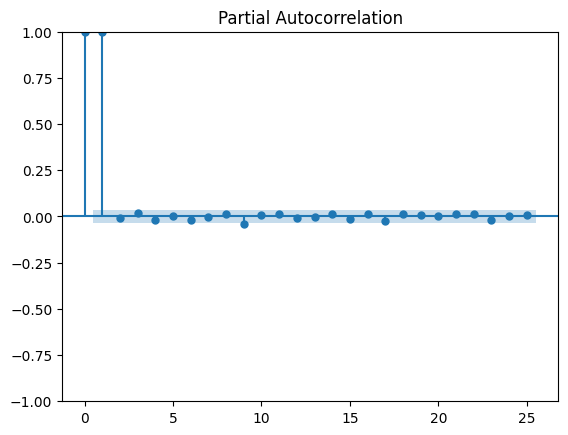

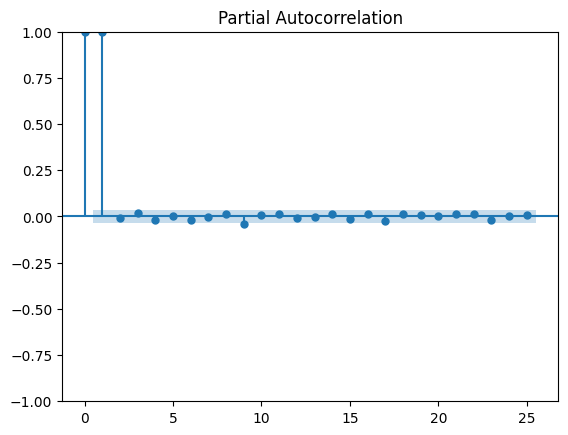

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Close'],lags=25)

In [ ]:
# Menentukan Timestep yang Akan Dipakai
n_lookback = 30

In [ ]:
# Menentukan Proporsi Pembagian Data Training dan Data Testing
SPLIT_TIME_TRAIN_VAL = int(math.floor(0.75*((len(df))/n_lookback)) * n_lookback)
SPLIT_TIME_TRAIN_VAL

2040

In [ ]:
data_train = df[:SPLIT_TIME_TRAIN_VAL]['Close']
data_train = pd.DataFrame(data_train)
data_train.index = df[:SPLIT_TIME_TRAIN_VAL]['Date']

data_val = df[SPLIT_TIME_TRAIN_VAL:]['Close']
data_val = pd.DataFrame(data_val)
data_val.index = df[SPLIT_TIME_TRAIN_VAL:]['Date']

print(len(data_train)/len(df))
print(len(data_val)/len(df))

0.7483492296404989
0.2516507703595011


In [ ]:
# Melihat Data Training/Pelatihan
data_train.head()

,Close
Date,
2013-02-01,1862
2013-03-01,1862
2013-04-01,1900
2013-07-01,1900
2013-08-01,1937


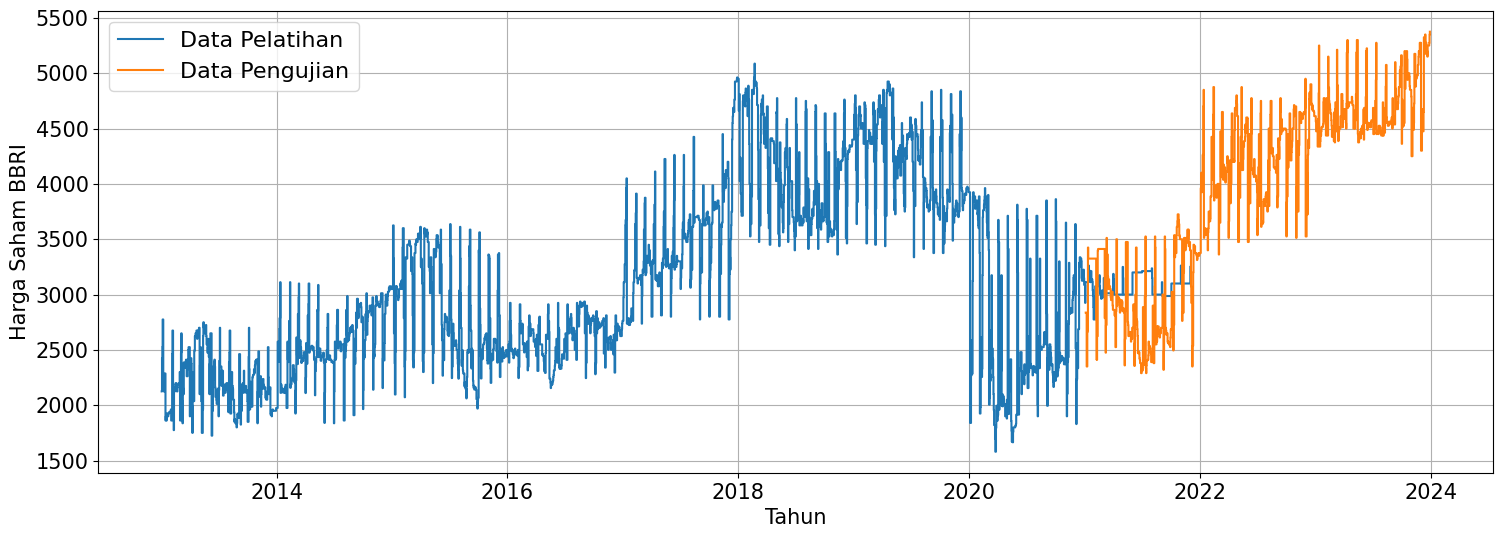

In [ ]:
# Plot Pembagian Data Training dan Data Testing
plt.subplots(figsize = (18,6))
ax=sns.lineplot(x="Date", y="Close",
             data=data_train, drawstyle='steps-post', label='Data Pelatihan')
ax=sns.lineplot(x="Date", y="Close",
             data=data_val, drawstyle='steps-post', label='Data Pengujian')
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Tahun', fontsize=15); plt.ylabel('Harga Saham BBRI', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.grid()

In [ ]:
# Mengubah Dimensi Dataset
bbri = df["Close"].values.reshape(-1, 1)

bbri_train = data_train.values.reshape(-1, 1)

bbri_val = data_val.values.reshape(-1, 1)

print(bbri_train.shape);print(bbri_val.shape)

(2040, 1)
(686, 1)


In [ ]:
# Melihat Data Pelatihan yang Sudah Diubah Dimensinya
bbri_train[:5]

array([[1862],
       [1862],
       [1900],
       [1900],
       [1937]])

In [ ]:
# Membuat Variabel Baru x_train dan y_train
x_train = []
y_train = []

for i in range(n_lookback, len(bbri_train)):
    x_train.append(bbri_train[i - n_lookback: i])
    y_train.append(bbri_train[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(2010, 30, 1)
(2010, 1)


In [ ]:
# Membuat Variabel Baru x_val dan y_val
x_val = []
y_val = []

for i in range(n_lookback, len(bbri_val)):
    x_val.append(bbri_val[i - n_lookback: i])
    y_val.append(bbri_val[i])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(656, 30, 1)
(656, 1)


In [ ]:
# Scalling Dataset
bbri_scaled = normalize_series(bbri, Average(bbri), stdev(bbri.flatten()))

bbri_train_scaled = normalize_series(bbri_train, Average(bbri_train), stdev(bbri_train.flatten()))

bbri_val_scaled = normalize_series(bbri_val, Average(bbri_val), stdev(bbri_val.flatten()))

In [ ]:
# Data Sebelum Dilakukan Scalling
bbri[0:5]

array([[1862],
       [1862],
       [1900],
       [1900],
       [1937]])

In [ ]:
# Data Sesudah Dilakukan Scalling
bbri_scaled[0:5]

array([[-1.62470597],
       [-1.62470597],
       [-1.58274243],
       [-1.58274243],
       [-1.54188319]])

In [ ]:
# Membuat Feature dan label Untuk Data Pelatihan Dari Data yang Sudah Discalling
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(bbri_train_scaled)):
    x_train_scaled.append(bbri_train_scaled[i - n_lookback: i])
    y_train_scaled.append(bbri_train_scaled[i])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(2010, 30, 1)
(2010, 1)


In [ ]:
# Melihat Dimensi Dari Data Pertama
print(x_train[0].shape)

(30, 1)


In [ ]:
# Membuat Feature dan label Untuk Data Pengujian Dari Data yang Sudah Di scalling
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(bbri_val_scaled)):
    x_val_scaled.append(bbri_val_scaled[i - n_lookback: i])
    y_val_scaled.append(bbri_val_scaled[i])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(656, 30, 1)
(656, 1)


In [ ]:
# Membuat Arsitektur Model yang Akan Digunakan

# Model LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=False, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.5), input_shape=(n_lookback,1)))
model.add(Dense(1))
model.compile(loss='huber', optimizer=Adam(learning_rate=0.00005))

In [ ]:
# Menentukan File Tujuan Untuk Menyimpan Bobot Model
filepath = "best_model.h5"

# Membuat ModelCheckpoint Callback Untuk Menyimpan Bobot Model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min')

# Membuat Konfigurasi EarlyStopping Callback yang Berfungsi Untuk Memberhentikan Proses Training Ketika Nilai Loss Berhenti Membaik
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Fit the model to the data
history = model.fit(x_train_scaled, y_train_scaled, epochs=2000, validation_data=(x_val_scaled, y_val_scaled) ,batch_size=64,verbose=1, callbacks=[checkpoint, early_stopping])

Epoch 1/2000
32/32 [==============================] - 3s 31ms/step - loss: 1.5741 - val_loss: 1.5417
Epoch 2/2000
32/32 [==============================] - 1s 33ms/step - loss: 1.5198 - val_loss: 1.4894
Epoch 3/2000
32/32 [==============================] - 1s 31ms/step - loss: 1.4664 - val_loss: 1.4377
Epoch 4/2000
32/32 [==============================] - 1s 23ms/step - loss: 1.4128 - val_loss: 1.3857
Epoch 5/2000
32/32 [==============================] - 1s 22ms/step - loss: 1.3585 - val_loss: 1.3333
Epoch 6/2000
32/32 [==============================] - 1s 24ms/step - loss: 1.3022 - val_loss: 1.2792
Epoch 7/2000
32/32 [==============================] - 1s 26ms/step - loss: 1.2421 - val_loss: 1.2219
Epoch 8/2000
32/32 [==============================] - 1s 34ms/step - loss: 1.1734 - val_loss: 1.1579
Epoch 9/2000
32/32 [==============================] - 1s 36ms/step - loss: 1.0840 - val_loss: 1.0801
Epoch 10/2000
32/32 [==============================] - 1s 37ms/step - loss: 1.0149 - val_lo

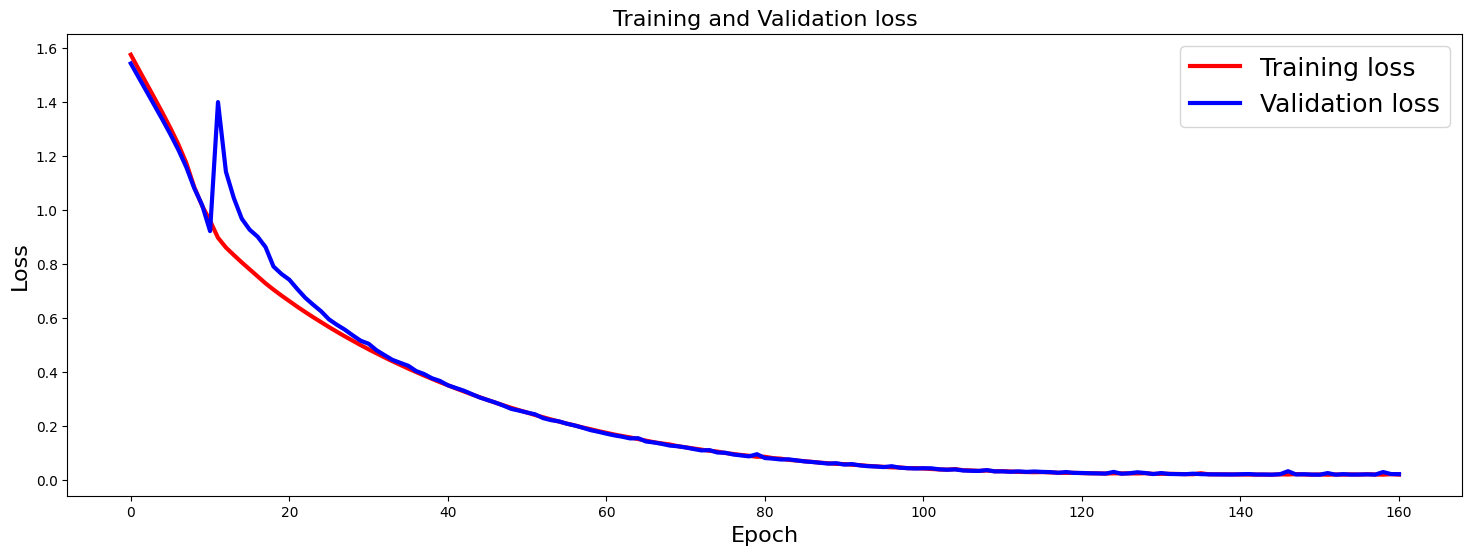

In [ ]:
# Plot Loss Dari Model Peramalan
plt.figure(figsize=[18,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation loss',fontsize=16)
plt.show()

In [ ]:
forecast_train_data = model_forecast(model,bbri_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(bbri_train_scaled.shape[0]-n_lookback)

2011/2011 [==============================] - 8s 4ms/step
(2011, 1)
(2010,)
2010


In [ ]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(bbri_train), stdev(bbri_train.flatten()))
forecast_train_data[:5]

array([2147.74494701, 2162.17872386, 2176.71851878, 2187.0091682 ,
       2191.95399242])

In [ ]:
actual = np.squeeze(bbri_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(2010,)
[2187 2200 2162 2125 2125]


In [ ]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
0,2013-02-14,2187,2147.744947
1,2013-02-15,2200,2162.178724
2,2013-02-18,2162,2176.718519
3,2013-02-19,2125,2187.009168
4,2013-02-20,2125,2191.953992
...,...,...,...
2005,2021-03-03,3012,3033.611944
2006,2021-04-03,3000,3033.373907
2007,2021-05-03,3000,3032.202459
2008,2021-08-03,3000,3029.362173


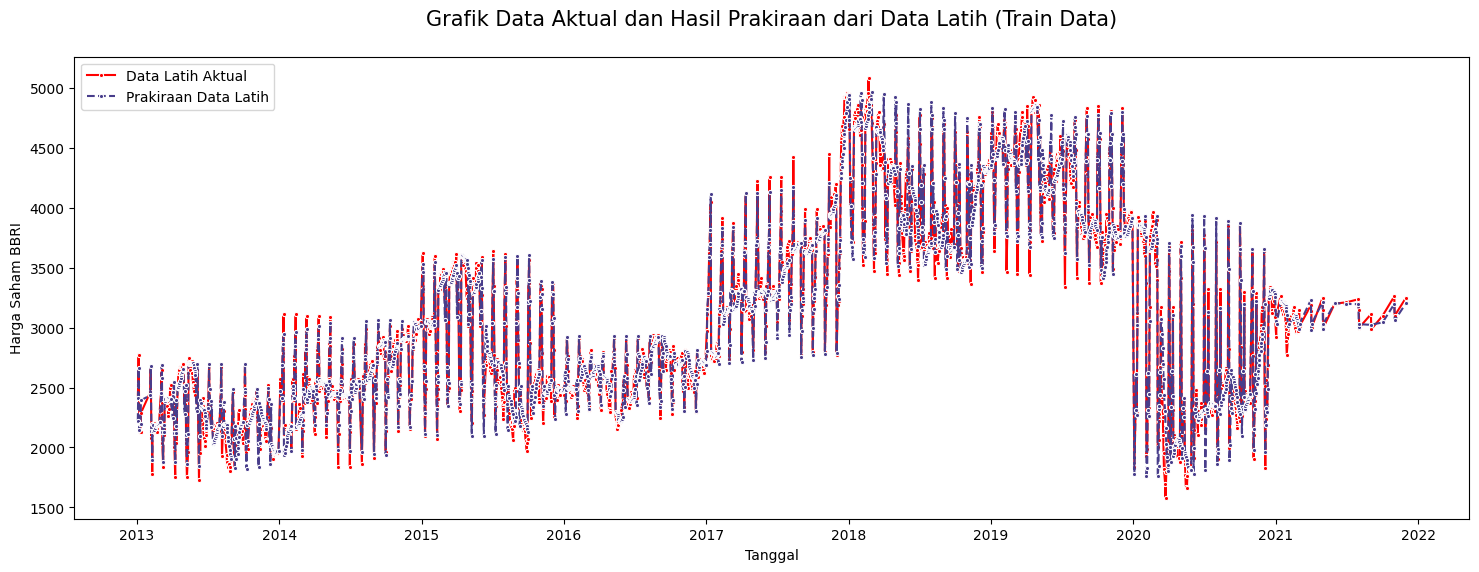

In [ ]:
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Data Latih Aktual", marker='.', color = 'red')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Prakiraan Data Latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BBRI')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  123.9069
MAE:  88.8979
MAPE:  0.029662


In [ ]:
forecast_val_data = model_forecast(model, bbri_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(bbri_val_scaled.shape[0]-n_lookback)

657/657 [==============================] - 2s 4ms/step
(657, 1)
(656,)
656


In [ ]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(bbri_val), stdev(bbri_val.flatten()))
forecast_val_data[:5]

array([2957.33316085, 2950.73819014, 2940.99282881, 2939.51736495,
       2936.94790694])

In [ ]:
actual = np.squeeze(bbri_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(656,)
[2887 2862 2950 2912 2937]


In [ ]:
len(data_val[-forecast_val_data.shape[0]:])

656

In [ ]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

,Date,Actual,Forecast
0,2021-04-23,2887,2957.333161
1,2021-04-26,2862,2950.738190
2,2021-04-27,2950,2940.992829
3,2021-04-28,2912,2939.517365
4,2021-04-29,2937,2936.947907
...,...,...,...
651,2023-12-21,5150,5242.231232
652,2023-12-22,5250,5229.931550
653,2023-12-27,5275,5225.346955
654,2023-12-28,5350,5224.469880


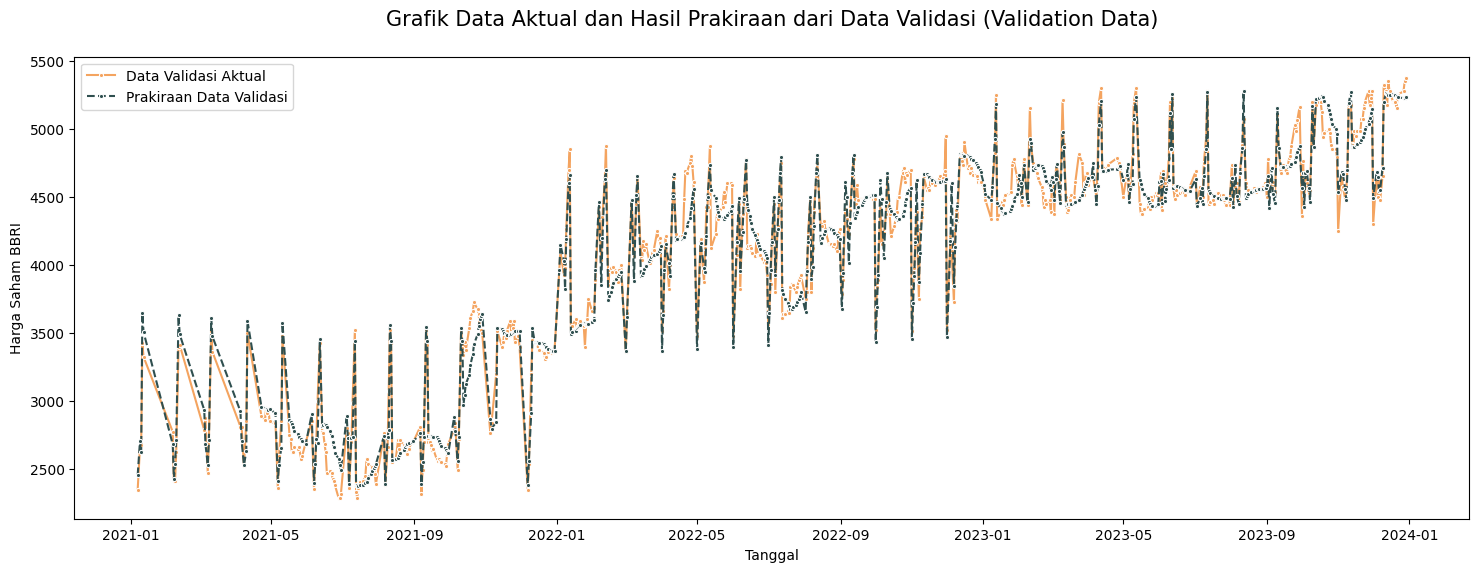

In [ ]:
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Data Validasi Aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Prakiraan Data Validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BBRI')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Val Accuracy
RMSE:  126.0156
MAE:  94.7126
MAPE:  0.024574


In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  123.9069
MAE:  88.8979
MAPE:  0.029662
Forecast Val Accuracy
RMSE:  126.0156
MAE:  94.7126
MAPE:  0.024574


In [ ]:
# Meramalkan Untuk 15 Periode Ke Depan
forecast_values = multi_step_forecasts(n_lookback=n_lookback, n_forecast=727, model=model, data=bbri, data_scaled=bbri_scaled)

1/1 [==============================] - 0s 28ms/step


In [ ]:
# Rentang Tanggal Yang Akan Diramal
date_forecast = [dt.strftime('%Y-%m-%d') for dt in
       datetime_range(datetime(2024, 1, 2), datetime(2025, 12, 29),
       relativedelta(days=1))]

print(np.shape(date_forecast))

(727,)


In [ ]:
# Hasil Peramalan
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = date_forecast
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.squeeze(forecast_values)
df_forecast

,Date,Forecast
0,2024-01-02,5225.134703
1,2024-01-03,5231.335997
2,2024-01-04,5236.106871
3,2024-01-05,5236.882262
4,2024-01-06,5234.434996
...,...,...
722,2025-12-24,4535.113585
723,2025-12-25,4535.105528
724,2025-12-26,4535.098814
725,2025-12-27,4535.087950


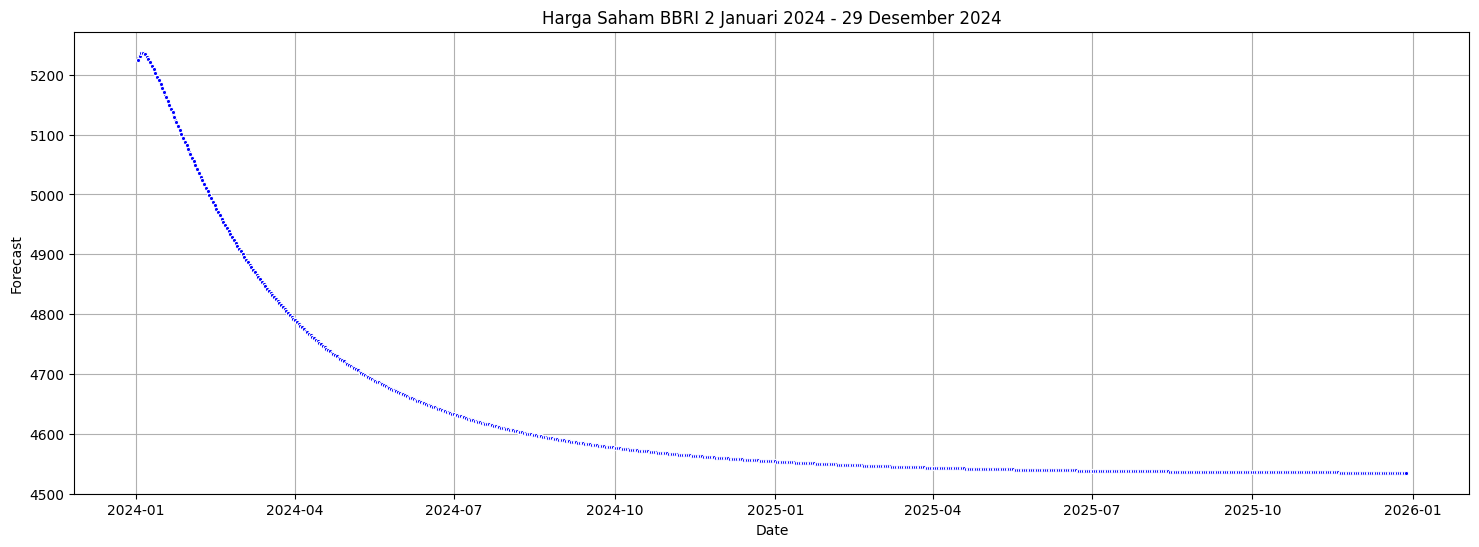

In [ ]:
# Plot Hasil Peramalan
from turtle import color

plt.subplots(figsize = (18,6))
sns.lineplot(x="Date", y="Forecast",
             data=df_forecast, marker='.', color = 'blue')
plt.title("Harga Saham BBRI 2 Januari 2024 - 29 Desember 2024")
plt.grid()

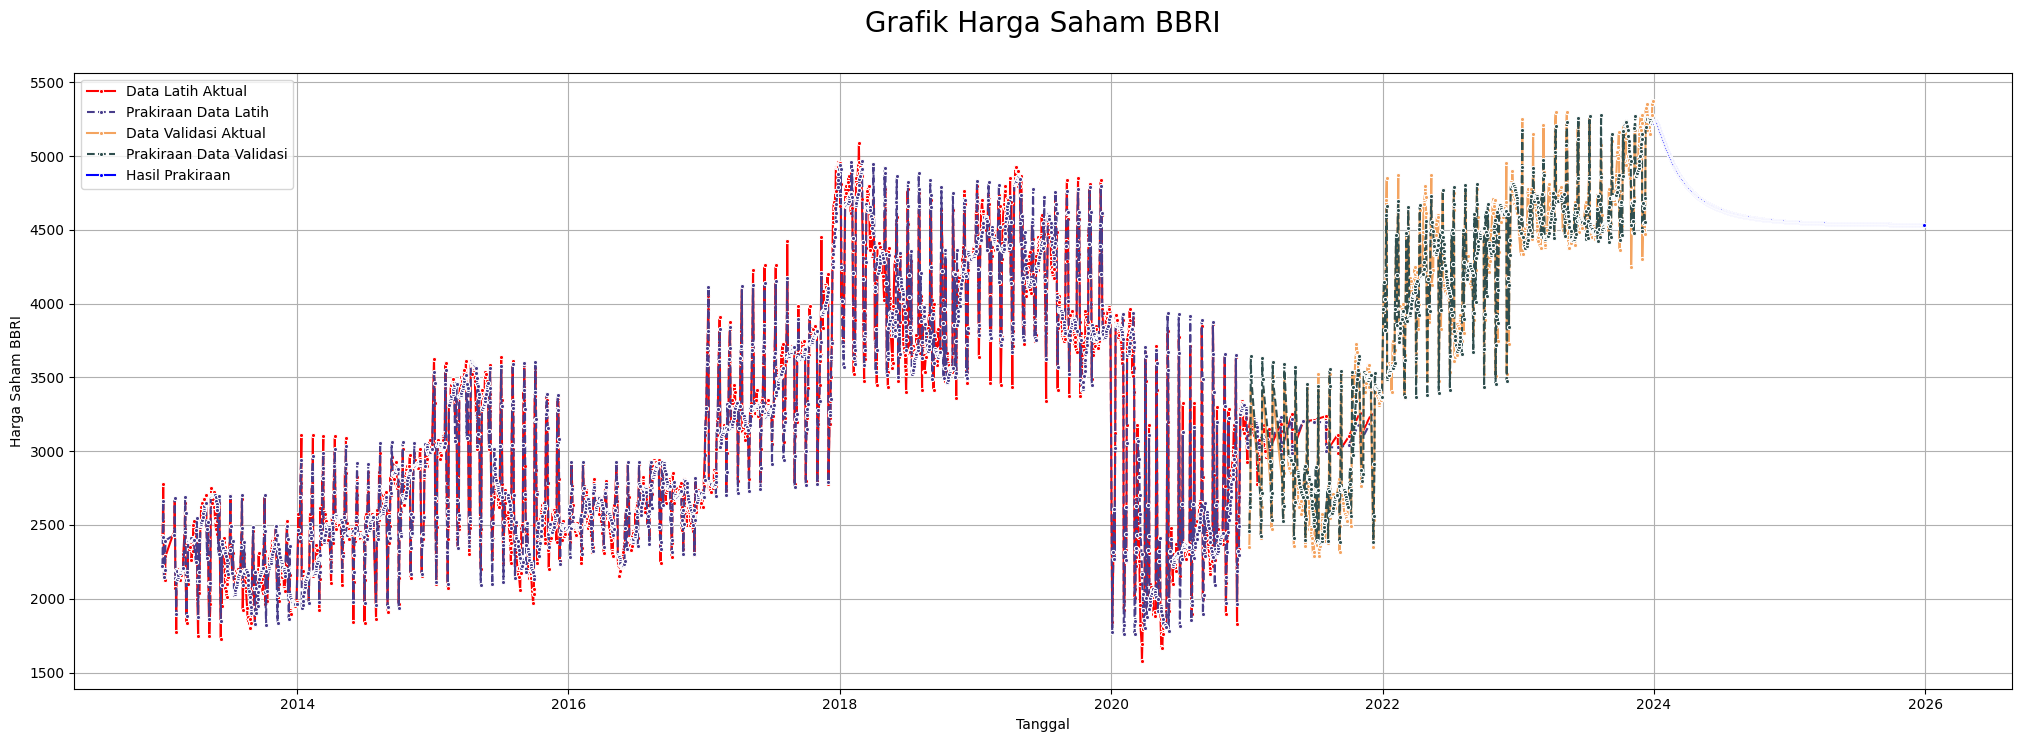

In [ ]:
# Plot Data Aktual dan Hasil Peramalan
fig, ax = plt.subplots(figsize = (25,8))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Data Latih Aktual", marker='.', color='red')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Prakiraan Data Latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Data Validasi Aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Prakiraan Data Validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Hasil Prakiraan", marker='.', color = 'blue')
plt.grid()
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BBRI')
plt.title("Grafik Harga Saham BBRI\n", fontsize = 20)
plt.legend(loc='upper left')

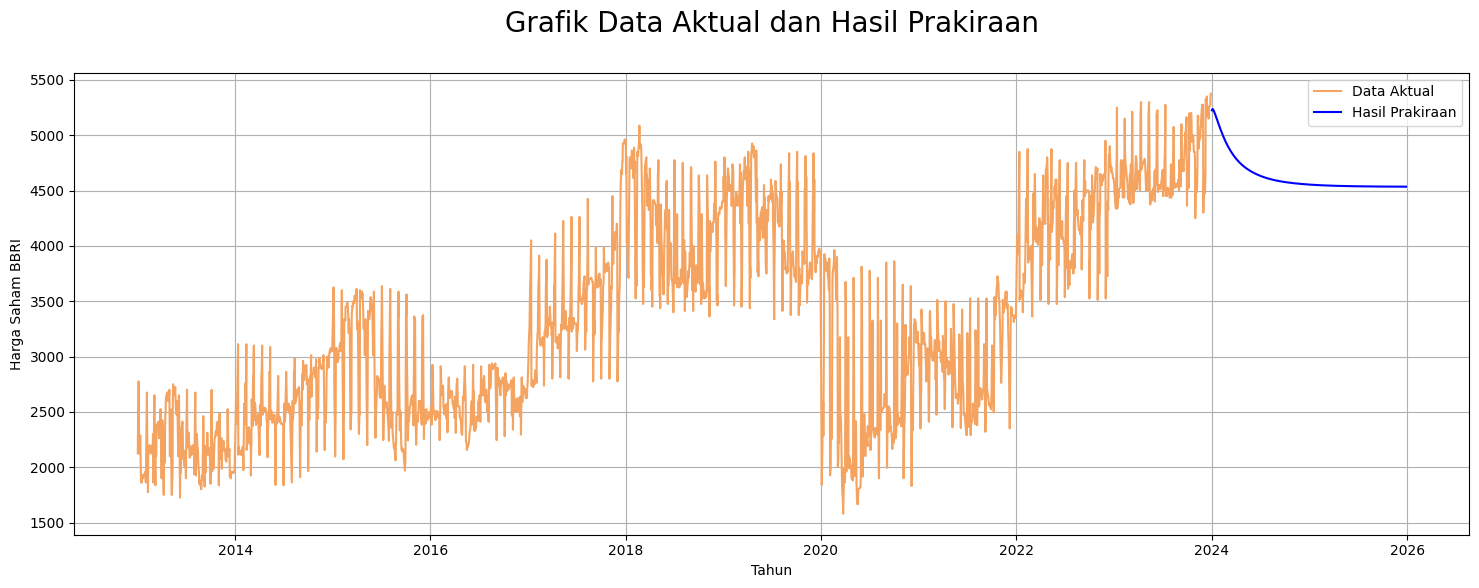

In [ ]:
fig, ax = plt.subplots(figsize = (18,6))
ax = sns.lineplot(x="Date", y="Close", data=df,
                    label="Data Aktual", color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Hasil Prakiraan", color='blue')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.xlabel('Tahun'); plt.ylabel('Harga Saham BBRI')
plt.grid()